# Classificação Multiclasse Probabilística (Dataset Iris)

Neste experimento, foram comparados dois modelos de Rede Neural Multicamadas (MLP) aplicados ao dataset **Iris**:

- **Modelo Base:** Uma arquitetura simples, com uma única camada oculta de 10 neurônios, função de ativação ReLU e solucionador Adam.
- **Modelo Otimizado:** Uma arquitetura ajustada automaticamente com o auxílio do **Optuna**, variando o número de camadas, neurônios e parâmetros de treinamento.

O objetivo era verificar se a busca automática por hiperparâmetros seria capaz de melhorar o desempenho do modelo em um problema de classificação multiclasse.

In [ ]:
!pip install optuna

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import warnings
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings("ignore", category=UserWarning, module="optuna")
warnings.filterwarnings("ignore", module="sklearn")

In [ ]:
def get_iris_data_train_test(test_size, random_state):
  data = load_iris()
  X, y = data.data, data.target
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  return train_test_split(X_scaled, y, test_size=test_size, random_state=random_state, stratify=y)

X_train, X_test, y_train, y_test = get_iris_data_train_test(0.2, 42)

In [ ]:
def build_and_fit_base_model():
  base_model = MLPClassifier(
      hidden_layer_sizes=(10,),
      activation='relu',
      solver='adam',
      max_iter=1000,
      random_state=42
  )
  base_model.fit(X_train, y_train)
  return base_model

base_model = build_and_fit_base_model()

In [ ]:
def build_and_fit_optimized_model_optuna(n_trials=80):

    def objective(trial):

        hidden_layer_sizes = trial.suggest_categorical(
            "hidden_layer_sizes",
            [(5,), (10,), (20,), (30,), (20, 10), (30, 10)]
        )

        activation = trial.suggest_categorical("activation", ["relu", "tanh"])
        solver = trial.suggest_categorical("solver", ["adam", "lbfgs"])

        alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)

        learning_rate_init = trial.suggest_float(
            "learning_rate_init", 1e-4, 1e-2, log=True
        )

        model = MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            solver=solver,
            alpha=alpha,
            learning_rate_init=learning_rate_init,
            max_iter=1500,
            early_stopping=False,
            random_state=42
        )

        scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=10,
            scoring="accuracy"
        )

        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("\nMelhores hiperparâmetros encontrados:")
    print(study.best_params)
    print(f"Melhor accuracy (CV): {study.best_value:.4f}")

    optimized_model = MLPClassifier(
        **study.best_params,
        max_iter=1500,
        random_state=42
    )

    optimized_model.fit(X_train, y_train)

    return optimized_model

optimize_model = build_and_fit_optimized_model_optuna()

[I 2025-11-30 15:26:54,793] A new study created in memory with name: no-name-fb65206e-1ec3-4fc3-9bd2-359312f7154e


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2025-11-30 15:26:57,525] Trial 0 finished with value: 0.9583333333333333 and parameters: {'hidden_layer_sizes': (20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0070186608848113495, 'learning_rate_init': 0.0007005322764678243}. Best is trial 0 with value: 0.9583333333333333.
[I 2025-11-30 15:27:07,655] Trial 1 finished with value: 0.9249999999999998 and parameters: {'hidden_layer_sizes': (5,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00013459206942377635, 'learning_rate_init': 0.00022965426422944072}. Best is trial 0 with value: 0.9583333333333333.
[I 2025-11-30 15:27:20,077] Trial 2 finished with value: 0.9583333333333333 and parameters: {'hidden_layer_sizes': (20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.002901945168763698, 'learning_rate_init': 0.0001705713895530611}. Best is trial 0 with value: 0.9583333333333333.
[I 2025-11-30 15:27:23,004] Trial 3 finished with value: 0.9666666666666666 and parameters: {'hidden_layer_sizes': (5,), 'activati

In [ ]:

models = {'Base': base_model, 'Otimizado': optimize_model}
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    loss = log_loss(y_test, y_proba)

    results[name] = {'acc': acc, 'f1': f1, 'loss': loss}
    print(f"\n# {name}:")
    print(f" * Acurácia: {acc:.4f} | F1-Score: {f1:.4f} | Cross-Entropy Loss: {loss:.4f}")


# Base:
 * Acurácia: 0.9667 | F1-Score: 0.9666 | Cross-Entropy Loss: 0.1083

# Otimizado:
 * Acurácia: 0.9667 | F1-Score: 0.9666 | Cross-Entropy Loss: 0.1371


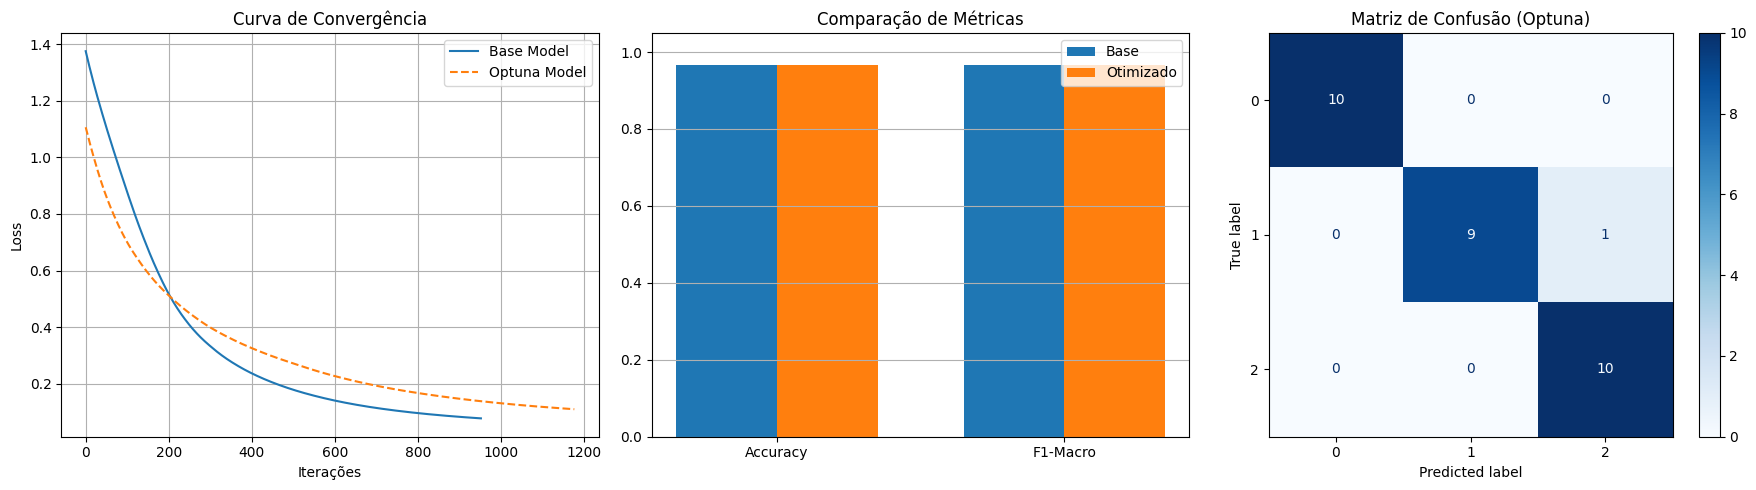

In [ ]:
def plot_results_optuna(base_model, optuna_model, results, X_test, y_test):

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    if hasattr(base_model, "loss_curve_"):
        axes[0].plot(base_model.loss_curve_, label='Base Model')

    if hasattr(optuna_model, "loss_curve_"):
        axes[0].plot(optuna_model.loss_curve_, label='Optuna Model', linestyle='--')

    axes[0].set_title('Curva de Convergência')
    axes[0].set_xlabel('Iterações')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    metrics = ['acc', 'f1']
    x = np.arange(len(metrics))
    width = 0.35

    rects1 = axes[1].bar(
        x - width / 2,
        [results['Base'][m] for m in metrics],
        width,
        label='Base'
    )

    rects2 = axes[1].bar(
        x + width / 2,
        [results['Otimizado'][m] for m in metrics],
        width,
        label='Otimizado'
    )

    axes[1].set_title('Comparação de Métricas')
    axes[1].set_xticks(x, ['Accuracy', 'F1-Macro'])
    axes[1].set_ylim(0, 1.05)
    axes[1].legend()
    axes[1].grid(axis='y')

    ConfusionMatrixDisplay.from_estimator(
        optuna_model,
        X_test,
        y_test,
        ax=axes[2],
        cmap='Blues'
    )

    axes[2].set_title('Matriz de Confusão (Optuna)')

    plt.tight_layout()
    plt.show()

plot_results_optuna(base_model, optimize_model, results, X_test, y_test)


## Análise dos Resultados

Os dois modelos atingiram praticamente o mesmo desempenho em termos de acurácia e F1-score, indicando que o modelo base já é suficiente para resolver o problema com alta precisão.

O modelo otimizado via Optuna apresentou menor Loss (0,1154), sugerindo melhor ajuste interno, porém sem ganho prático em classificação.

Isso reforça que, em um dataset simples e bem separado como o Iris, o aumento de complexidade não se traduz em melhoria significativa, validando o princípio de que modelos mais simples podem ser tão eficientes quanto modelos otimizados automaticamente.
